## Code Description:

1. **Configuration Import (`config`)**: This line imports a `config` module, likely containing custom settings or credentials used later in the project (e.g., database connection strings).

2. **Pandas Library (`pd`)**: The `pandas` library is imported for data manipulation. Pandas is a powerful tool for working with tabular data, essential for filtering, cleaning, and processing the BDOT10k data.

3. **Matplotlib (`plt`)**: The `matplotlib.pyplot` library is imported for data visualization. This will be useful for generating plots and graphs, such as visualizing the solar irradiance and slope parameters used in the analysis.

4. **FixedLocator**: This specific import from `matplotlib.pyplot` is used to fix the location of ticks in plots, which is likely to come in handy when visualizing geographically linked data.

5. **SQLAlchemy (`create_engine`)**: The `create_engine` function from SQLAlchemy is imported, hinting that a database connection (likely PostGIS or other spatial databases) will be established. This allows seamless integration between the database and Python for querying and managing geospatial data.

6. **Precision Setting**: The pandas display precision is set to 2 decimal places, ensuring that all floating-point data (e.g., slope angles or solar irradiance) are consistently displayed with two digits of precision in any DataFrame outputs.

---

This is an introductory setup cell that establishes the necessary libraries and configurations for data manipulation, visualization, and database integration in the subsequent analysis. Let me know if you need any further adjustments!


In [1]:
# Import necessary libraries and modules
import config
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import FixedLocator
from sqlalchemy import create_engine

# Set display option for pandas DataFrames to limit float precision to 2 decimal places
pd.set_option("display.precision", 2)

# Database Connection Setup

1. **Configuration Data:**
   - The **`mysql`** dictionary is imported from the **`config`** module, which stores database credentials such as the username, password, host, port, and database name.

2. **Connection String:**
   - A PostgreSQL connection string is constructed using the credentials from the **`mysql`** dictionary.
   - The connection string follows the format: 
     ```
     postgresql://<user>:<password>@<host>:<port>/<dbname>
     ```

3. **Database Engine:**
   - The **`create_engine()`** function from SQLAlchemy is used to create a connection engine, which allows communication with the PostgreSQL database. This will enable efficient querying and manipulation of data stored in the database.

4. **Connection:**
   - The **`conn`** object is created by calling **`engine.connect()`**, which establishes an active connection to the database. This connection can now be used to perform SQL queries and retrieve the required data for analysis.

This step is critical as it sets up the database connection, allowing access to the data needed for analyzing potential wind and solar farm locations.


In [2]:
# Import database configuration
mysql = config.mysql

# Construct PostgreSQL connection string
connection_string = (
    f"postgresql://{mysql['user']}:{mysql['password']}@"
    f"{mysql['host']}:{mysql['port']}/{mysql['dbname']}"
)

# Create database engine
engine = create_engine(connection_string)

## Defining Polish Provinces

This section defines a list of Polish provinces that will be used for data filtering or selection purposes during the analysis. Each province represents a geographical region in Poland, where the potential locations for wind and solar farms will be evaluated.

The list includes the names of all 16 provinces (województwa) in Poland:

- Dolnośląskie
- Kujawsko-pomorskie
- Lubelskie
- Lubuskie
- Łódzkie
- Małopolskie
- Mazowieckie
- Opolskie
- Podkarpackie
- Podlaskie
- Pomorskie
- Śląskie
- Świętokrzyskie
- Warmińsko-mazurskie
- Wielkopolskie
- Zachodniopomorskie

This list will likely be used later in the analysis to subset data or run analyses for specific regions.


In [3]:
# Define a list of Polish provinces (województwa)
provinces = [
    "dolnoslaskie",
    "kujawsko_pomorskie",
    "lubelskie",
    "lubuskie",
    "lodzkie",
    "malopolskie",
    "mazowieckie",
    "opolskie",
    "podkarpackie",
    "podlaskie",
    "pomorskie",
    "slaskie",
    "swietokrzyskie",
    "warminsko_mazurskie",
    "wielkopolskie",
    "zachodniopomorskie"
]


## Renewable Energy Potential by Province

This section calculates the total potential area available for solar and wind energy production across Polish provinces. It retrieves data from two types of tables:

- **Solar photovoltaic potential area**: Calculated from `solar_radiation_photovoltaic_area_{province}` tables.
- **Wind energy potential area**: Calculated from `wind_speed_area_{province}` tables.

The data for each province is fetched from a PostgreSQL database, and the total area for both solar and wind potential is computed. The result is presented in square kilometers (km²) for easier interpretation.

### Steps:

1. **Data Initialization**:
    - Two dictionaries, `solar_area_append_total` and `wind_area_append_total`, are created to store the results for each province.

2. **Data Extraction**:
    - For each province, the corresponding table names for solar and wind energy data are generated.
    - SQL queries are constructed to sum up the available area (`SUM(area)`) for both solar and wind in each province.

3. **Data Validation**:
    - After fetching data using `pd.read_sql`, it is checked whether valid data was retrieved. If no data is found or the area is `None`, the area is set to 0.

4. **Unit Conversion**:
    - The area is converted from square meters (m²) to square kilometers (km²) using a factor of `1e-6`, and the result is rounded to 2 decimal places.

5. **Data Storage**:
    - The calculated values are appended to the dictionaries, which are later converted into Pandas DataFrames for both solar and wind areas.

The resulting DataFrames, `df_solar` and `df_wind`, hold the calculated total potential area for renewable energy in each province.


In [4]:
# Initialize dictionaries to store total renewable areas for solar and wind by province
solar_area_append_total = {'Province': [], 'solar_area': []}
wind_area_append_total = {'Province': [], 'wind_area': []}

# Establish persistent connection to the database
conn = engine.connect()

# Import data from the database for each province
for province in provinces:
    
    # Define table names for solar and wind data
    table_name_solar = f"solar_radiation_photovoltaic_area_{province}"
    table_name_wind = f"wind_speed_area_{province}"
  
    # SQL queries to get the total area for solar and wind energy
    query_solar = (f"SELECT SUM(area) as solar_total_area FROM {table_name_solar}")
    query_wind = (f"SELECT SUM(area) as wind_total_area FROM {table_name_wind}")
    
    # Execute queries and store results in pandas DataFrames
    solar_result = pd.read_sql(query_solar, conn)
    wind_result = pd.read_sql(query_wind, conn)
    
    # Check if valid data is retrieved, set area to 0 if data is missing
    solar_area = solar_result['solar_total_area'][0] if not solar_result.empty and solar_result['solar_total_area'][0] is not None else 0
    wind_area = wind_result['wind_total_area'][0] if not wind_result.empty and wind_result['wind_total_area'][0] is not None else 0
    
    # Append results to the respective lists, converting m² to km²
    solar_area_append_total['Province'].append(province)
    solar_area_append_total['solar_area'].append(round(solar_area * 1e-6, 2))
    
    wind_area_append_total['Province'].append(province)
    wind_area_append_total['wind_area'].append(round(wind_area * 1e-6, 2))


# Convert the dictionaries to pandas DataFrames
df_solar = pd.DataFrame(solar_area_append_total)
df_wind = pd.DataFrame(wind_area_append_total)

# Display the solar potential area DataFrame
df_solar

,Province,solar_area
0,dolnoslaskie,480.64
1,kujawsko_pomorskie,262.50
2,lubelskie,594.29
3,lubuskie,326.41
4,lodzkie,485.20
5,malopolskie,441.87
6,mazowieckie,1344.64
7,opolskie,90.20
8,podkarpackie,568.48
9,podlaskie,962.12


## Visualization of Renewable Energy Potential

The bar plot below illustrates the total area available for solar and wind energy generation for each province in Poland. The blue bars represent the potential area for solar energy, while the green bars represent the potential area for wind energy. The data is presented in square kilometers (km²).

This visualization provides an easy comparison of the renewable energy potential across different regions, showing how provinces differ in their capacity for both solar and wind energy development.

- **X-axis**: Names of the provinces.
- **Y-axis**: Total area available for renewable energy (km²).
- **Bars**:
    - **Blue**: Solar energy potential.
    - **Green**: Wind energy potential.

The plot highlights the variation in renewable resource availability, which is crucial for planning large-scale energy projects.


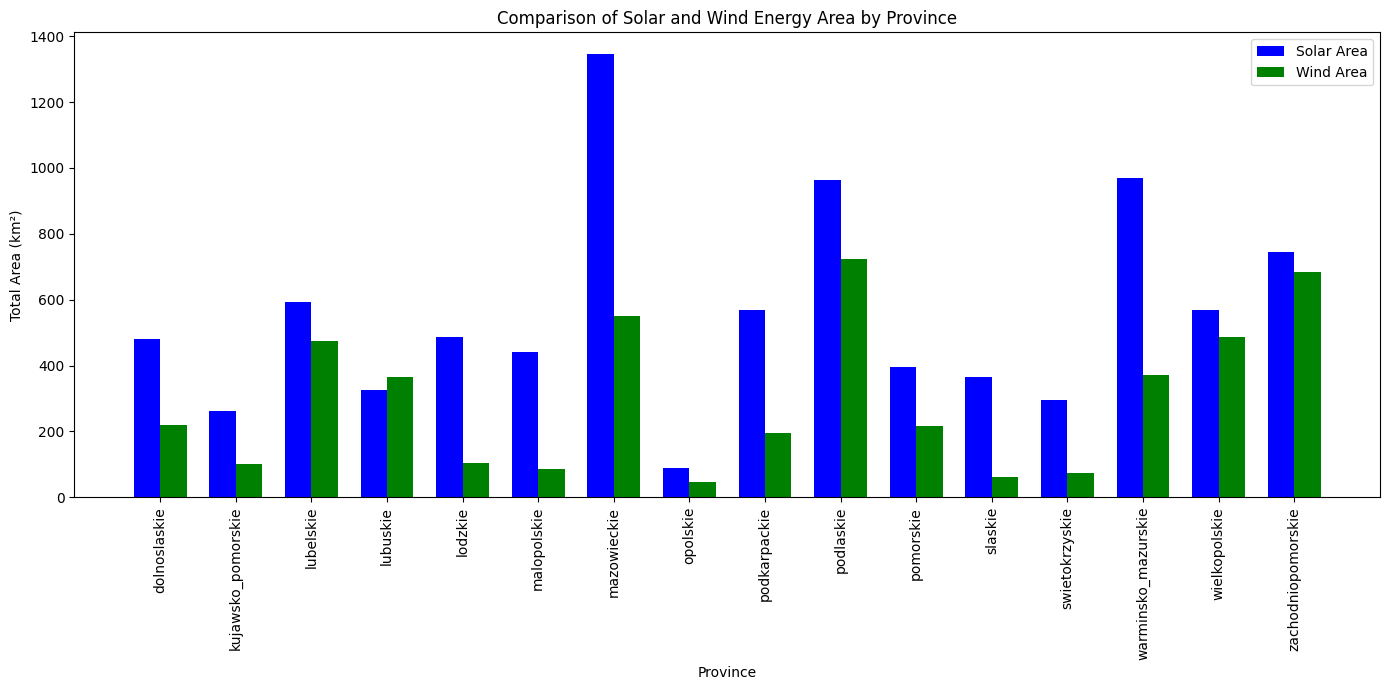

In [5]:
# Create a bar plot to compare solar and wind energy areas by province
plt.figure(figsize=(14, 7))
width = 0.35  # Width of the bars

# Position of the bars for each province
ind = range(len(df_solar['Province']))

# Create bars for solar and wind energy areas
plt.bar(ind, df_solar['solar_area'], width=width, label='Solar Area', color='blue')
plt.bar([i + width for i in ind], df_wind['wind_area'], width=width, label='Wind Area', color='green')

# Add labels, title, and format the x-ticks
plt.xlabel('Province')
plt.ylabel('Total Area (km²)')
plt.title('Comparison of Solar and Wind Energy Area by Province')
plt.xticks([i + width / 2 for i in ind], df_solar['Province'], rotation=90)

# Add legend and display the plot
plt.legend()
plt.tight_layout()
plt.show()

Photovoltaic Panel Parameters and Effective Area Calculation
In this section, we calculate the effective area available for photovoltaic (PV) panel installations. Key factors include the size and efficiency of the panels, as well as adjustments to account for space required for equipment and maintenance access.

Key Parameters:
Panel Size: Each panel has a height of 1.016 m and a width of 1.686 m, giving a surface area of approximately 1.71 m².
Power Output: The standard power output of a panel is 0.350 kW, leading to a power output of around 0.205 kW per square meter (kW/m²).
Efficiency: The panel efficiency is calculated under standard conditions of 25°C and 1000 W/m², with an efficiency close to 20%.
Effective Area: We cannot use the entire area for panels, as some space (20%) must be allocated for equipment and maintenance access, meaning only 80% of the area is available for PV panels.
The code below calculates the effective solar panel area in each province, taking into account these factors.

In [6]:
# Photovoltaic standard panel parameters
height_panel = 1.016  # Height of a single panel in meters
width_panel = 1.686  # Width of a single panel in meters
power_output = 0.350  # Power output per panel in kW
power_output_m2 = power_output / (height_panel * width_panel)  # Power output per m²

# Efficiency of the panel under standard conditions (~20% efficiency)
efficiency = (power_output / (height_panel * width_panel * 1))

# Parameters for effective solar area (80% area used for panels, 20% for equipment and access)
solar_maintenance_access = 0.2  # 20% area reserved for equipment and access
effective_solar_panel_area = 1 - solar_maintenance_access  # 80% area for PV panels

# Calculate the effective solar area for each province
df_solar['solar_effective_area'] = df_solar['solar_area'] * effective_solar_panel_area

# Display the DataFrame with the new column
df_solar

,Province,solar_area,solar_effective_area
0,dolnoslaskie,480.64,384.51
1,kujawsko_pomorskie,262.50,210.00
2,lubelskie,594.29,475.43
3,lubuskie,326.41,261.13
4,lodzkie,485.20,388.16
5,malopolskie,441.87,353.50
6,mazowieckie,1344.64,1075.71
7,opolskie,90.20,72.16
8,podkarpackie,568.48,454.78
9,podlaskie,962.12,769.70


Solar Radiation Calculation by Province and Month
This section calculates the total solar energy potential for each province based on monthly solar radiation data. The calculation considers the available photovoltaic area, panel efficiency, and monthly sunlight duration. The final data is merged into the df_solar DataFrame.

Key Steps:
Months Dictionary: A dictionary with the number of days in each month is defined.
Query Construction: For each province and month, a SQL query is used to sum up the total area available for photovoltaic installations, multiply it by monthly solar radiation, adjust for panel efficiency, and account for the 80% effective area utilization.
Energy Calculation: The resulting energy is converted from kW to MW for easier interpretation.
Data Merging: The calculated solar radiation data is merged with the existing df_solar DataFrame.


In [7]:
# Dictionary containing months and their respective number of days
months = {
    "january": 31,
    "february": 28,
    "march": 31,
    "april": 30,
    "may": 31,
    "june": 30,
    "july": 31,
    "august": 31,
    "september": 30,
    "october": 31,
    "november": 30,
    "december": 31
}

# DataFrame to store solar radiation by province and month
solar_radiation = pd.DataFrame(index=provinces, columns=months.keys())

# Loop through each province and month to calculate solar radiation
for province in provinces:
    for month in months:
        table_name_solar = f"solar_radiation_photovoltaic_area_{province}"
        
        # SQL query to calculate total solar energy in the month (accounting for area, radiation, efficiency)
        query = (f"SELECT SUM(area * {months[month]} * {effective_solar_panel_area} * {efficiency}) "
                 f"AS total FROM {table_name_solar}")
        
        # Execute the query and store result in DataFrame
        result_df = pd.read_sql(query, conn)
        monthly_solar_energy = result_df.iloc[0]['total'] if not result_df.empty else 0
        
        # Convert from kW to MW and store in the DataFrame
        solar_radiation.at[province, month] = round(monthly_solar_energy * 1e-3, 2)

# Reset index and rename columns
solar_radiation.reset_index(inplace=True)
solar_radiation.rename(columns={'index': 'Province'}, inplace=True)

# Merge the solar radiation data with the df_solar DataFrame
df_solar = df_solar.merge(solar_radiation, left_on='Province', right_on='Province')

# Functional Assumptions for Wind Energy

- **Turbines per km²**: We assume 3 wind turbines for every square kilometer of wind-available land.
- **Wind Turbine Model**: The parameters for the Vestas V100 turbine are as follows:
    - Minimum wind speed for operation: **3 m/s**
    - Maximum wind speed for operation: **22 m/s**
    - Maximum energy generation: **2 MW** (at 22 m/s)


In [8]:
# Functional assumption: 3 wind turbines per km²
turbine_number_for_area = 3
df_wind['turbines_number'] = df_wind['wind_area'] * turbine_number_for_area
df_wind['turbines_number'] = df_wind['turbines_number'].astype(int)

# Parameters for wind turbine Vestas V100
# Minimum wind speed [m/s]
minimum_wind_speed = 3

# Maximum wind speed [m/s]
maximum_wind_speed = 22

# Energy generated per hour at 22 m/s wind speed [MW]
maximum_power_generate = 2

df_wind


,Province,wind_area,turbines_number
0,dolnoslaskie,220.40,661
1,kujawsko_pomorskie,100.90,302
2,lubelskie,473.40,1420
3,lubuskie,366.51,1099
4,lodzkie,104.86,314
5,malopolskie,86.31,258
6,mazowieckie,551.29,1653
7,opolskie,47.03,141
8,podkarpackie,195.24,585
9,podlaskie,722.85,2168


# Wind Energy Calculation by Province

For each province, we calculate the wind energy generated per month using the following assumptions:

- **Wind Speed Thresholds**:
    - **Minimum Wind Speed**: 3 m/s (below this, no energy is generated)
    - **Maximum Wind Speed**: 22 m/s (maximum energy output at this speed)

- **Energy Generation Formula**:
    - Energy generated is proportional to the wind speed up to 22 m/s.
    - For wind speeds above 3 m/s, the energy generated per hour is calculated based on the wind speed ratio compared to the maximum wind speed.

For each month, the energy generated is calculated in MW for every province.


In [9]:
# Create a DataFrame for wind energy
wind_energy = pd.DataFrame(index=provinces, columns=months.keys())

# Loop through each province and month to calculate wind energy
for province in provinces:
    for month, days in months.items():
        table_name_wind = f"wind_speed_area_{province}"
        
        # Select data in tables and calculate energy generated for 1 month in MW
        query = (f"SELECT SUM(CASE "
                 f"WHEN {month} > {minimum_wind_speed} THEN ((({month} * 24 * {days}) / {maximum_wind_speed}) * {maximum_power_generate}) "
                 f"ELSE 0 "
                 f"END) as total "
                 f"FROM {table_name_wind}")

        # Fetch result into pandas
        result_df = pd.read_sql(query, conn)
        monthly_wind_speed = result_df.iloc[0]['total'] if not result_df.empty else 0
        
        # Round the result and assign it to the DataFrame
        monthly_wind_speed = round(monthly_wind_speed, 2)
        wind_energy.at[province, month] = monthly_wind_speed
        
# Rename index for merging
wind_energy.reset_index(inplace=True)
wind_energy.rename(columns={'index': 'Province'}, inplace=True)

# Merge wind energy data with the existing df_wind DataFrame
df_wind = df_wind.merge(wind_energy, left_on='Province', right_on='Province')

df_wind

,Province,wind_area,turbines_number,january,february,march,april,may,june,july,august,september,october,november,december
0,dolnoslaskie,220.40,661,447120,396744,423090,120640,0,0,0,0,11440,256770,325520,445230
1,kujawsko_pomorskie,100.90,302,115072,97600,108000,104000,65340,60840,12960,0,97240,108000,104000,108000
2,lubelskie,473.40,1420,534060,482632,534060,162760,18090,0,0,0,41340,477630,514280,534060
3,lubuskie,366.51,1099,423630,382836,423630,11180,0,0,0,0,1300,394470,407940,423630
4,lodzkie,104.86,314,214228,170800,189000,181480,96390,0,0,0,164840,189000,182000,189816
5,malopolskie,86.31,258,103950,93940,103950,1560,0,0,0,0,0,31860,43160,68580
6,mazowieckie,551.29,1653,741136,663192,733860,232960,68040,4420,0,0,182000,693630,706680,733860
7,opolskie,47.03,141,126900,114680,117180,49140,5670,0,0,0,14300,83160,96200,126900
8,podkarpackie,195.24,585,369900,334280,353160,30420,0,0,0,0,0,273240,355940,383670
9,podlaskie,722.85,2168,344790,311588,344790,147680,8640,0,0,0,109720,344790,332020,344790


# Solar Radiation Analysis by Province

For each province, we calculate the solar radiation energy production and the estimated building costs for photovoltaic panels. We perform the following operations:

- **Area and Distances**:
    - Area in km²
    - Line distance and road distance in km

- **Solar Energy Production**:
    - Total and monthly energy production (in MWh) calculated based on the effective solar panel area and panel efficiency.

- **Construction Cost**:
    - The construction cost (in millions of PLN) is calculated based on the energy production, using a tiered cost approach.

- **Solar Radiation Difference**:
    - The difference in solar radiation values between the maximum monthly radiation and the total sum of all months.

Each province is processed, and the resulting DataFrame is stored in a dictionary for easy access.


In [10]:
# Initialize a dictionary to store the solar radiation data for each province
solar_radiation_photovoltaic_area_by_each_province = {}

# Loop through each province to calculate solar radiation and other metrics
for province in provinces:
    
    # Define the table name for the current province
    table_name = f"solar_radiation_photovoltaic_area_{province}"
    
    # Define the sum of monthly columns for solar radiation difference calculation
    sum_columns = ' + '.join(months)
    
    # Define the SQL query for fetching solar radiation and energy production data
    query = (
        f"SELECT "
        f"id, "
        f"area * 1e-6 AS area_km2, "
        f"line_dista * 1e-3 AS line_distance_km, "
        f"road_dista * 1e-3 AS road_distance_km, "
        f"area * {effective_solar_panel_area} * {efficiency} * 1e-3 AS solar_energy_production_mwh, "
        
        # Monthly energy production
        f"area * {effective_solar_panel_area} * {efficiency} * january * 1e-3 AS january_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * february * 1e-3 AS february_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * march * 1e-3 AS march_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * april * 1e-3 AS april_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * may * 1e-3 AS may_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * june * 1e-3 AS june_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * july * 1e-3 AS july_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * august * 1e-3 AS august_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * september * 1e-3 AS september_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * october * 1e-3 AS october_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * november * 1e-3 AS november_solar_energy_production_mwh, "
        f"area * {effective_solar_panel_area} * {efficiency} * december * 1e-3 AS december_solar_energy_production_mwh, "
        
        # Building cost calculation
        f"CASE "
        f"    WHEN area * {effective_solar_panel_area} * {efficiency} * 1e-3 < 0.5 THEN 3.51 * area * {effective_solar_panel_area} * {efficiency} * 1e-3 "
        f"    WHEN area * {effective_solar_panel_area} * {efficiency} * 1e-3 <= 1 THEN 2.63 * area * {effective_solar_panel_area} * {efficiency} * 1e-3 "
        f"    WHEN area * {effective_solar_panel_area} * {efficiency} * 1e-3 > 1 THEN 2.05 * area * {effective_solar_panel_area} * {efficiency} * 1e-3 "
        f"    ELSE 0 "
        f"END AS building_cost_mln_zl, "
        
        # Solar radiation difference
        f"((SELECT MAX(value) FROM (SELECT {sum_columns} AS value FROM {table_name}) subquery) - ({sum_columns})) AS solar_radiation_difference_kw "
        
        f"FROM {table_name}"
    )
    
    # Execute the SQL query and load the result into a pandas DataFrame
    result_df = pd.read_sql(query, conn)
    
    # Copy the result DataFrame for the current province
    solar_radiation_photovoltaic_area_by_each_province[province] = result_df.copy()
    
    # Calculate the annual energy production and add it as a new column
    solar_radiation_photovoltaic_area_by_each_province[province]['energy_production_by_year_mwh'] = \
        solar_radiation_photovoltaic_area_by_each_province[province].loc[:, 'january_solar_energy_production_mwh':'december_solar_energy_production_mwh'].sum(axis=1)

In [11]:
solar_radiation_photovoltaic_area_by_each_province['podlaskie']


,id,area_km2,line_distance_km,road_distance_km,solar_energy_production_mwh,january_solar_energy_production_mwh,february_solar_energy_production_mwh,march_solar_energy_production_mwh,april_solar_energy_production_mwh,may_solar_energy_production_mwh,june_solar_energy_production_mwh,july_solar_energy_production_mwh,august_solar_energy_production_mwh,september_solar_energy_production_mwh,october_solar_energy_production_mwh,november_solar_energy_production_mwh,december_solar_energy_production_mwh,building_cost_mln_zl,solar_radiation_difference_kw,energy_production_by_year_mwh
0,2.0,0.08,4.39e-01,0.00,12.74,331.24,751.66,1465.11,2229.51,2841.03,3095.83,2917.47,2356.91,1592.51,879.06,394.94,229.32,26.12,97,19084.59
1,4.0,0.06,7.86e-03,0.00,9.31,242.14,549.48,1071.02,1629.82,2076.86,2263.12,2132.73,1722.95,1164.16,642.61,288.71,167.64,19.09,97,13951.25
2,6.0,0.03,4.01e-01,0.05,4.36,113.34,252.83,501.31,767.22,976.46,1059.29,998.26,806.46,544.90,300.79,135.14,78.47,8.94,96,6534.47
3,7.0,0.13,1.21e-01,0.00,20.50,533.00,1209.51,2357.52,3587.52,4571.53,4981.53,4694.53,3792.53,2562.52,1414.51,635.50,369.00,42.03,97,30709.21
4,8.0,0.03,4.66e-01,0.00,4.99,129.65,294.20,578.44,882.61,1116.98,1216.71,1146.90,927.49,628.30,344.07,154.58,89.76,10.22,89,7509.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9692,13019.0,0.02,1.95e-01,0.00,3.37,104.57,212.51,401.42,610.56,765.73,836.57,802.83,664.53,458.76,263.11,121.44,74.21,6.92,19,5316.24
9693,13020.0,0.08,0.00e+00,0.00,12.49,387.30,787.09,1486.73,2261.34,2836.04,3098.41,2973.47,2461.23,1699.13,974.50,449.77,274.86,25.61,19,19689.87
9694,13021.0,0.02,2.39e-01,0.00,4.03,124.97,253.96,479.71,729.64,915.07,999.73,959.41,794.14,548.24,314.43,145.12,88.69,8.26,19,6353.10
9695,13022.0,0.04,7.49e-02,0.00,5.80,179.86,365.53,690.44,1050.17,1317.06,1438.90,1380.88,1143.00,789.07,452.56,208.87,127.64,11.89,19,9143.98


# Function to Calculate Cost Parameters Based on Road and Line Distance

We define a function that calculates cost parameters for road and power line distances for each province. The function normalizes the distances according to the following assumptions:
- **Line distance**: Maximum allowed distance is 500 meters.
- **Road distance**: 1 km is considered the base unit, and the cost increases with distance.

Additionally, we calculate other parameters:
- **Solar radiation difference parameter**: Normalized based on the minimum and maximum differences in solar radiation values.
- **Energy production parameter**: Negative values are normalized for energy production to reflect higher costs for lower production.


In [12]:
def calculate_cost_parameters(province_data):
    """
    Function to calculate cost parameters based on road and line distance for solar energy production.

    Args:
        province_data (pd.DataFrame): DataFrame containing the solar radiation data for a specific province.

    Returns:
        pd.DataFrame: Updated DataFrame with new cost parameters.
    """
    # Calculate road and line distance parameters (normalization between 0 and 1)
    parametr_line_distance = (province_data['line_distance_km'] - province_data['line_distance_km'].min()) / (province_data['line_distance_km'].max() - province_data['line_distance_km'].min())
    parametr_road_distance = (province_data['road_distance_km'] - province_data['road_distance_km'].min()) / (province_data['road_distance_km'].max() - province_data['road_distance_km'].min())

    # Assign normalized parameters to DataFrame
    province_data['road_distance_cost_parametr'] = parametr_road_distance
    province_data['line_distance_cost_parametr'] = parametr_line_distance

    # Normalize solar radiation difference
    province_data['solar_radiation_difference_parametr'] = (province_data['solar_radiation_difference_kw'] - province_data['solar_radiation_difference_kw'].min()) / (province_data['solar_radiation_difference_kw'].max() - province_data['solar_radiation_difference_kw'].min())
    
    # Copy DataFrame for temporary modification
    temp_df = province_data.copy()
    
    # Convert energy production values to negative and normalize them
    temp_df['energy_production_by_year_mwh'] = -1 * temp_df['energy_production_by_year_mwh']
    province_data['solar_radiation_energy_parametr'] = (temp_df['energy_production_by_year_mwh'] - temp_df['energy_production_by_year_mwh'].min()) / (temp_df['energy_production_by_year_mwh'].max() - temp_df['energy_production_by_year_mwh'].min())
    
    return province_data

# Apply the function to each province and update the corresponding DataFrame
for province in provinces:    
    df = solar_radiation_photovoltaic_area_by_each_province[province]
    
    # Calculate and update cost parameters for each province
    solar_radiation_photovoltaic_area_by_each_province[province] = calculate_cost_parameters(df)


# Optimization of Solar Panel Placement Based on Cost Parameters

This code is designed to optimize the placement of solar panels based on four weighted cost parameters:
- **`w_1`**: Weight for the distance from the road
- **`w_2`**: Weight for the distance from power lines
- **`w_3`**: Weight for the difference in solar radiation
- **`w_4`**: Weight for the energy production potential in the area

The objective function calculates a value based on the input weights for these parameters. The goal is to minimize the negative contribution of road and power line distances while maximizing solar radiation and energy production potential.

The optimization process explores different combinations of these weights to find the best configuration.


In [13]:
import numpy as np
from scipy.optimize import minimize, Bounds

# Weights for different parameters
w_1 = 0.3  # Weight for road distance
w_2 = 0.4  # Weight for line distance
w_3 = 0.1  # Weight for solar radiation difference
w_4 = 0.2  # Weight for energy production

# Objective function definition
def objective(x, weights):
    """
    Objective function to minimize the placement costs for solar panels based on weighted parameters.

    Args:
        x (list): List of parameter values [road_distance, line_distance, solar_radiation_diff, energy_production].
        weights (list): Weights for each parameter.

    Returns:
        float: Objective function value to minimize.
    """
    return -weights[0] * x[0] - weights[1] * x[1] + weights[2] * x[2] + weights[3] * x[3]

# Initial guesses for parameter values (starting point)
initial_values = [0.5, 0.5, 0.5, 0.5]  

# Bounds for the parameter values (0 to 1 range for normalization)
bounds = Bounds([0, 0, 0, 0], [1, 1, 1, 1])  

# Generate different sets of weights for exploration (combinations of weights in 0.4 increments)
weight_sets = [(w1, w2, w3, w4) for w1 in np.linspace(w_1, w_1 + 0.4, 5)
                                  for w2 in np.linspace(w_2, w_2 + 0.4, 5)
                                  for w3 in np.linspace(w_3, w_3 + 0.4, 5)
                                  for w4 in np.linspace(w_4, w_4 + 0.4, 5)]

# Calculating Objective Value for Solar Panel Placement by Province

The function `calculate_objective` is used to compute an objective value for each province. This value is based on:
- **`w1`**: Weight for the cost associated with road distance.
- **`w2`**: Weight for the cost associated with the distance from power lines.
- **`w3`**: Weight for the solar radiation difference.
- **`w4`**: Weight for the energy production potential in the area.

For each province, the objective value is calculated and stored as a new column in the dataset, allowing for comparison and further analysis.


In [14]:
# Function to calculate the objective value based on the given weights and parameters
def calculate_objective(row, w1, w2, w3, w4):
    """
    Calculate the objective value for a given row based on weights for different parameters.

    Args:
        row (pd.Series): A row of data containing the parameters to calculate the objective value.
        w1 (float): Weight for road distance cost parameter.
        w2 (float): Weight for line distance cost parameter.
        w3 (float): Weight for solar radiation difference parameter.
        w4 (float): Weight for solar radiation energy parameter.

    Returns:
        float: The computed objective value for the row.
    """
    return (-w1 * row['road_distance_cost_parametr'] - w2 * row['line_distance_cost_parametr']
            + w3 * row['solar_radiation_difference_parametr'] + w4 * row['solar_radiation_energy_parametr'])

# Iterate through each province and apply the objective value calculation
for province in provinces:
    # Add additional columns to the DataFrame for 'type' and 'province'
    solar_radiation_photovoltaic_area_by_each_province[province]['type'] = 'solar'
    solar_radiation_photovoltaic_area_by_each_province[province]['province'] = province

    # Calculate the objective value for each row using the given weights
    solar_radiation_photovoltaic_area_by_each_province[province]['objective_value'] = \
        solar_radiation_photovoltaic_area_by_each_province[province].apply(
            calculate_objective, axis=1, args=(w_1, w_2, w_3, w_4)
        )

# Energy Consumption by Region for 2022

This section loads and processes the energy consumption data for Poland's regions from the GUS (Central Statistical Office) for the year 2022. The following steps are performed:

1. The data is read from a CSV file.
2. Only the data for 2022 is selected.
3. The first row, containing the total consumption for the whole of Poland, is removed.
4. Energy consumption is converted from gigawatt (GW) to terawatt (TW).
5. The region names are standardized by replacing dashes with underscores and converting to lowercase.
6. Columns are renamed for better readability.


In [37]:
# Load energy consumption data from CSV file
energy_consumption_df = pd.read_csv('D:/GEOWORLDLOOK/OZE/PILOT/Data/ENERGY_CONSUMPTION/ENERGY_CONSUMPTION_BY_REGION.csv')

# Select data for the year 2022
energy_consumption_df_2022 = energy_consumption_df[['wojewodztwa', '2022']]

# Remove the first row which contains the total for Poland
energy_consumption_df_2022_by_region = energy_consumption_df_2022.drop(index=0)

# Convert energy consumption from gigawatts (GW) to terawatts (TW)
energy_consumption_df_2022_by_region['2022'] = energy_consumption_df_2022_by_region['2022'] * 1e-3

# Standardize region names (replace dashes with underscores and convert to lowercase)
energy_consumption_df_2022_by_region['wojewodztwa'] = energy_consumption_df_2022_by_region['wojewodztwa'].str.replace('-', '_').str.lower()

# Rename columns for clarity
energy_consumption_df_2022_by_region = energy_consumption_df_2022_by_region.rename(columns={'wojewodztwa': 'Province', '2022': 'energy_consumption_2022'})

# Display the processed DataFrame
energy_consumption_df_2022_by_region

,Province,energy_consumption_2022
1,dolnoslaskie,15.68
2,kujawsko_pomorskie,8.56
3,lubelskie,5.90
4,lubuskie,3.92
5,lodzkie,12.79
6,malopolskie,13.48
7,mazowieckie,30.17
8,opolskie,5.74
9,podkarpackie,5.65
10,podlaskie,3.41


# Energy Production and Consumption by Province

This analysis combines the effective area of solar and wind energy farms in each province, calculates the total monthly energy production for both solar and wind, and compares these values with the actual energy consumption in Poland in 2022.

The steps followed:
1. **Data Merging**: Solar and wind energy production data are merged based on provinces.
2. **Monthly Energy Summation**: The total monthly production of solar and wind energy is calculated by summing the individual month columns.
3. **Plotting**:
   - **Bar chart** (blue and red) represents the effective areas (in km²) dedicated to solar and wind energy production.
   - **Line chart** (green and yellow) represents the total energy production from solar and wind (in terawatt hours, tW).
   - **Line chart** (dashed red) compares the electricity consumption in 2022 for each province, also in tW.

The plot uses dual y-axes to represent both the effective area (left y-axis) and energy production/consumption (right y-axis) per province.


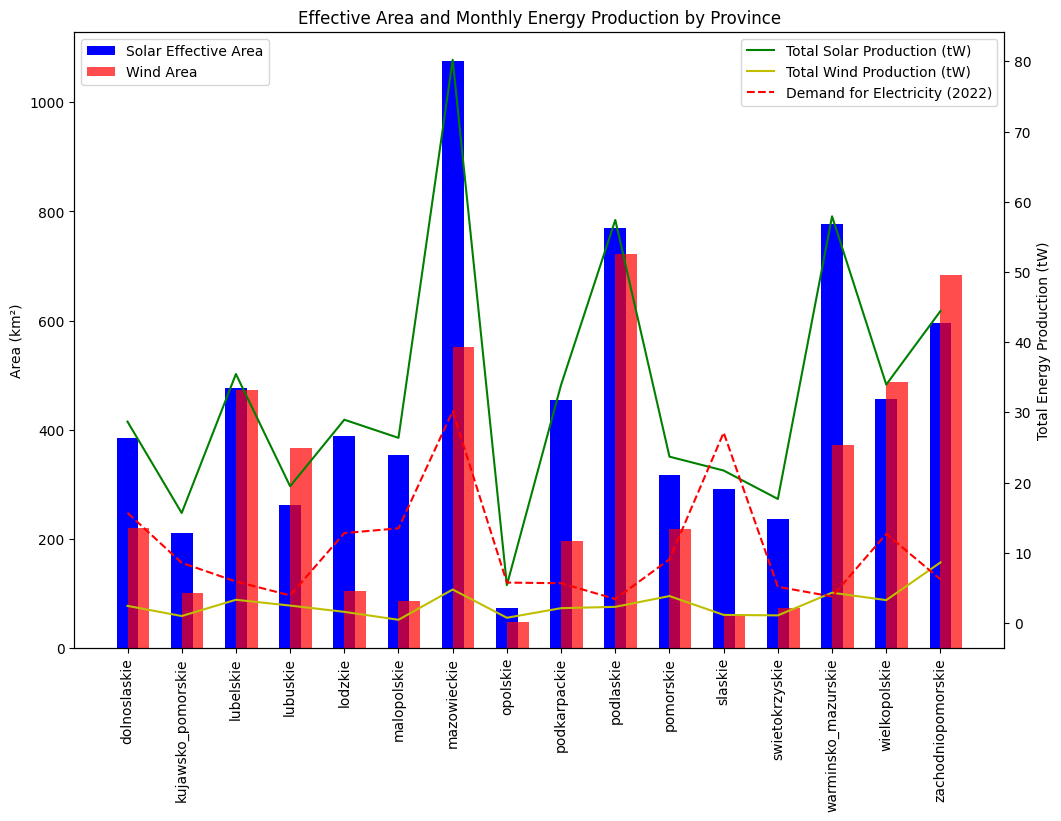

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import pandas as pd

# Merging solar and wind data by province
data_combined = pd.merge(df_solar, df_wind, on='Province', suffixes=('_solar_energy_production_mwh', '_wind_energy_production_mwh'))

# Summing monthly energy production for solar and wind
monthly_solar = data_combined.loc[:, 'january_solar_energy_production_mwh':'december_solar_energy_production_mwh'].sum(axis=1)
monthly_wind = data_combined.loc[:, 'january_wind_energy_production_mwh':'december_wind_energy_production_mwh'].sum(axis=1)

# Adjust wind production by number of turbines (if relevant data is available)
# monthly_wind = monthly_wind * df_wind['turbines_number']  # Uncomment if turbines_number is available

# Creating the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar chart for the effective areas of solar and wind energy
ax1.bar(data_combined['Province'], data_combined['solar_effective_area'], color='b', label='Solar Effective Area', width=0.4, align='center')
ax1.bar(data_combined['Province'], data_combined['wind_area'], color='r', alpha=0.7, label='Wind Area', width=0.4, align='edge')
ax1.set_ylabel('Area (km²)')
ax1.set_title('Effective Area and Monthly Energy Production by Province')
tick_locations = range(len(data_combined['Province']))  # Positions for each province
ax1.xaxis.set_major_locator(FixedLocator(tick_locations))
ax1.set_xticklabels(data_combined['Province'], rotation=90)
ax1.legend(loc='upper left')

# Line chart for solar and wind energy production and demand
ax2 = ax1.twinx()
ax2.plot(data_combined['Province'], monthly_solar * 1e-6, 'g-', label='Total Solar Production (tW)')
ax2.plot(data_combined['Province'], monthly_wind * 1e-6, 'y-', label='Total Wind Production (tW)')
ax2.plot(energy_consumption_df_2022_by_region['Province'], energy_consumption_df_2022_by_region['energy_consumption_2022'], 'r--', label='Demand for Electricity (2022)')

ax2.set_ylabel('Total Energy Production (tW)')
ax2.legend(loc='upper right')

# Show plot
plt.show()


# Summation and Comparison of Energy Production and Consumption

In this step, the total yearly production of solar and wind energy is calculated for each province. The data is then merged with the 2022 energy consumption data for each province, allowing us to compare energy production against actual consumption. The following steps are carried out:
1. **Summation of Annual Solar and Wind Energy Production**: We sum up the monthly energy production to calculate the total yearly production for both solar and wind energy.
2. **Merging with Consumption Data**: The calculated production data is merged with the energy consumption data for 2022 to allow for comparison.


In [43]:
# Summing annual solar and wind energy production
data_combined['sum_production_solar'] = data_combined.loc[:, 'january_solar_energy_production_mwh':'december_solar_energy_production_mwh'].sum(axis=1)
data_combined['sum_production_wind'] = data_combined.loc[:, 'january_wind_energy_production_mwh':'december_wind_energy_production_mwh'].sum(axis=1)

# Merging with the 2022 energy consumption data
data_combined = pd.merge(data_combined, energy_consumption_df_2022_by_region, on='Province')

# Display the updated DataFrame to verify the data
data_combined

,Province,solar_area,solar_effective_area,january_solar_energy_production_mwh,february_solar_energy_production_mwh,march_solar_energy_production_mwh,april_solar_energy_production_mwh,may_solar_energy_production_mwh,june_solar_energy_production_mwh,july_solar_energy_production_mwh,...,june_wind_energy_production_mwh,july_wind_energy_production_mwh,august_wind_energy_production_mwh,september_wind_energy_production_mwh,october_wind_energy_production_mwh,november_wind_energy_production_mwh,december_wind_energy_production_mwh,sum_production_solar,sum_production_wind,energy_consumption_2022
0,dolnoslaskie,480.64,384.51,2435480.17,2199788.54,2435480.17,2356916.3,2435480.17,2356916.3,2435480.17,...,0,0,0,11440,256770,325520,445230,28675814.93,2426554,15.68
1,kujawsko_pomorskie,262.50,210.00,1330117.29,1201396.26,1330117.29,1287210.28,1330117.29,1287210.28,1330117.29,...,60840,12960,0,97240,108000,104000,108000,15661058.41,981052,8.56
2,lubelskie,594.29,475.43,3011408.66,2719982.02,3011408.66,2914266.45,3011408.66,2914266.45,3011408.66,...,0,0,0,41340,477630,514280,534060,35456908.44,3298912,5.90
3,lubuskie,326.41,261.13,1653964.27,1493903.21,1653964.27,1600610.58,1653964.27,1600610.58,1653964.27,...,0,0,0,1300,394470,407940,423630,19474095.42,2468616,3.92
4,lodzkie,485.20,388.16,2458618.28,2220687.48,2458618.28,2379308.01,2458618.28,2379308.01,2458618.28,...,0,0,0,164840,189000,182000,189816,28948247.48,1577554,12.79
5,malopolskie,441.87,353.50,2239052.97,2022370.42,2239052.97,2166825.45,2239052.97,2166825.45,2239052.97,...,0,0,0,0,31860,43160,68580,26363043.01,447000,13.48
6,mazowieckie,1344.64,1075.71,6813578.59,6154200.02,6813578.59,6593785.74,6813578.59,6593785.74,6813578.59,...,4420,0,0,182000,693630,706680,733860,80224393.11,4759778,30.17
7,opolskie,90.20,72.16,457041.39,412811.57,457041.39,442298.11,457041.39,442298.11,457041.39,...,0,0,0,14300,83160,96200,126900,5381293.74,734130,5.74
8,podkarpackie,568.48,454.78,2880607.45,2601838.99,2880607.45,2787684.63,2880607.45,2787684.63,2880607.45,...,0,0,0,0,273240,355940,383670,33916829.66,2100610,5.65
9,podlaskie,962.12,769.70,4875261.72,4403462.2,4875261.72,4717995.21,4875261.72,4717995.21,4875261.72,...,0,0,0,109720,344790,332020,344790,57402275.08,2288808,3.41


# Identifying the Minimum Monthly Energy Production

In this step, we calculate the month with the minimum energy production for both solar and wind energy for each province. This will help identify periods of low energy production, which may be critical for assessing the stability of energy supply throughout the year.

The following steps are performed:
1. **Finding the Minimum Solar Energy Production Month**: The month with the lowest solar energy production is identified for each province.
2. **Finding the Minimum Wind Energy Production Month**: Similarly, the month with the lowest wind energy production is identified.


In [44]:
# Finding the month with the minimum solar energy production for each province
data_combined['min_value_solar'] = data_combined[['january_solar_energy_production_mwh',
       'february_solar_energy_production_mwh', 'march_solar_energy_production_mwh', 
       'april_solar_energy_production_mwh', 'may_solar_energy_production_mwh',
       'june_solar_energy_production_mwh', 'july_solar_energy_production_mwh', 
       'august_solar_energy_production_mwh', 'september_solar_energy_production_mwh',
       'october_solar_energy_production_mwh', 'november_solar_energy_production_mwh', 
       'december_solar_energy_production_mwh']].idxmin(axis=1)

# Finding the month with the minimum wind energy production for each province
data_combined['min_value_wind'] = data_combined[['january_wind_energy_production_mwh', 
       'february_wind_energy_production_mwh', 'march_wind_energy_production_mwh',
       'april_wind_energy_production_mwh', 'may_wind_energy_production_mwh', 
       'june_wind_energy_production_mwh', 'july_wind_energy_production_mwh', 
       'august_wind_energy_production_mwh', 'september_wind_energy_production_mwh', 
       'october_wind_energy_production_mwh', 'november_wind_energy_production_mwh', 
       'december_wind_energy_production_mwh']].idxmin(axis=1)

# Display the updated DataFrame
data_combined

,Province,solar_area,solar_effective_area,january_solar_energy_production_mwh,february_solar_energy_production_mwh,march_solar_energy_production_mwh,april_solar_energy_production_mwh,may_solar_energy_production_mwh,june_solar_energy_production_mwh,july_solar_energy_production_mwh,...,august_wind_energy_production_mwh,september_wind_energy_production_mwh,october_wind_energy_production_mwh,november_wind_energy_production_mwh,december_wind_energy_production_mwh,sum_production_solar,sum_production_wind,energy_consumption_2022,min_value_solar,min_value_wind
0,dolnoslaskie,480.64,384.51,2435480.17,2199788.54,2435480.17,2356916.3,2435480.17,2356916.3,2435480.17,...,0,11440,256770,325520,445230,28675814.93,2426554,15.68,february_solar_energy_production_mwh,may_wind_energy_production_mwh
1,kujawsko_pomorskie,262.50,210.00,1330117.29,1201396.26,1330117.29,1287210.28,1330117.29,1287210.28,1330117.29,...,0,97240,108000,104000,108000,15661058.41,981052,8.56,february_solar_energy_production_mwh,august_wind_energy_production_mwh
2,lubelskie,594.29,475.43,3011408.66,2719982.02,3011408.66,2914266.45,3011408.66,2914266.45,3011408.66,...,0,41340,477630,514280,534060,35456908.44,3298912,5.90,february_solar_energy_production_mwh,june_wind_energy_production_mwh
3,lubuskie,326.41,261.13,1653964.27,1493903.21,1653964.27,1600610.58,1653964.27,1600610.58,1653964.27,...,0,1300,394470,407940,423630,19474095.42,2468616,3.92,february_solar_energy_production_mwh,may_wind_energy_production_mwh
4,lodzkie,485.20,388.16,2458618.28,2220687.48,2458618.28,2379308.01,2458618.28,2379308.01,2458618.28,...,0,164840,189000,182000,189816,28948247.48,1577554,12.79,february_solar_energy_production_mwh,june_wind_energy_production_mwh
5,malopolskie,441.87,353.50,2239052.97,2022370.42,2239052.97,2166825.45,2239052.97,2166825.45,2239052.97,...,0,0,31860,43160,68580,26363043.01,447000,13.48,february_solar_energy_production_mwh,may_wind_energy_production_mwh
6,mazowieckie,1344.64,1075.71,6813578.59,6154200.02,6813578.59,6593785.74,6813578.59,6593785.74,6813578.59,...,0,182000,693630,706680,733860,80224393.11,4759778,30.17,february_solar_energy_production_mwh,july_wind_energy_production_mwh
7,opolskie,90.20,72.16,457041.39,412811.57,457041.39,442298.11,457041.39,442298.11,457041.39,...,0,14300,83160,96200,126900,5381293.74,734130,5.74,february_solar_energy_production_mwh,june_wind_energy_production_mwh
8,podkarpackie,568.48,454.78,2880607.45,2601838.99,2880607.45,2787684.63,2880607.45,2787684.63,2880607.45,...,0,0,273240,355940,383670,33916829.66,2100610,5.65,february_solar_energy_production_mwh,may_wind_energy_production_mwh
9,podlaskie,962.12,769.70,4875261.72,4403462.2,4875261.72,4717995.21,4875261.72,4717995.21,4875261.72,...,0,109720,344790,332020,344790,57402275.08,2288808,3.41,february_solar_energy_production_mwh,june_wind_energy_production_mwh


# Filtering Solar Radiation Data Based on Worst-Case Monthly Energy Production

This code filters solar radiation data for each province to ensure that the photovoltaic areas selected can generate enough energy in the worst possible month (December) to meet the monthly electricity demand of the province.

Key steps include:
1. **Sorting Solar Radiation Data by Objective Value**: Each province's data is sorted based on the pre-calculated objective value, in descending order, to prioritize the most optimal areas for solar energy production.
2. **Identifying Minimum Solar Energy Month**: For each province, the month with the lowest solar energy production (December in most cases) is identified, and cumulative production is calculated.
3. **Filtering Based on Energy Demand**: The areas are filtered until the cumulative energy production meets or exceeds the average monthly electricity consumption of the province in 2022.


In [46]:
# Create an empty dictionary to store the filtered data for each province
filtered_solar_radiation_photovoltaic_area_by_each_province = {}

# Loop through each province to filter data
for province in provinces:
    # Sort the province's data based on the 'objective_value' column in descending order
    solar_radiation_photovoltaic_area_by_each_province[province] = solar_radiation_photovoltaic_area_by_each_province[province].sort_values(by='objective_value', ascending=False)
    
    # Select the row corresponding to the current province from the combined data
    row = data_combined[data_combined['Province'] == province]
    
    # Identify the column corresponding to the month with the minimum solar energy production
    column = row['min_value_solar'].iloc[0]
    
    # Calculate the cumulative energy production (in TW) for the worst month
    solar_radiation_photovoltaic_area_by_each_province[province]['cumsum_tw'] = (solar_radiation_photovoltaic_area_by_each_province[province][column].cumsum()) * 1e-6
    
    # Select the row corresponding to the current province from the energy consumption data
    row_min = energy_consumption_df_2022_by_region[energy_consumption_df_2022_by_region['Province'] == province]
    
    # Calculate the average monthly energy consumption (in TW)
    value_min = row_min['energy_consumption_2022'].iloc[0] / 12
    
    # Filter the data to include only the areas where cumulative energy production is less than the average monthly consumption
    filtered_solar_radiation_photovoltaic_area_by_each_province[province] = solar_radiation_photovoltaic_area_by_each_province[province][solar_radiation_photovoltaic_area_by_each_province[province]['cumsum_tw'] < value_min]

# Energy Production Visualization by Province Over the Year

This code generates a line plot to visualize the monthly wind energy production in each province. The data is extracted from the `data_combined` DataFrame, and for each province, a separate line is drawn showing its energy production trend across the year.

Key steps:
1. **Data Preparation**: The DataFrame is set up with the monthly wind energy production data for each province.
2. **Line Plot for Each Province**: Each province's data is plotted as a separate line, showing the monthly energy production.
3. **Customization of Plot**: Titles, labels, and legends are added for better readability, and the x-axis labels (months) are rotated for clarity.


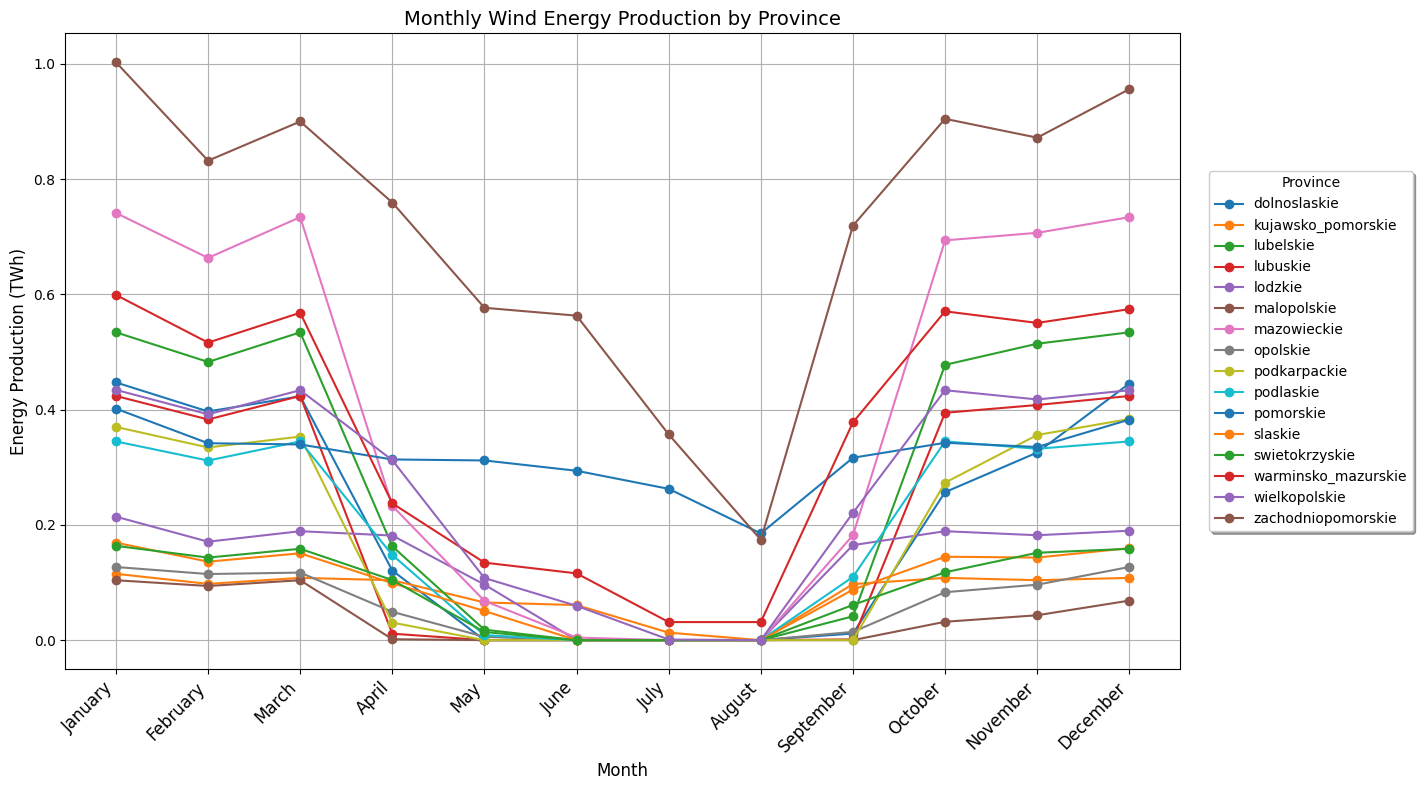

In [60]:
# Create a DataFrame from data_combined for wind energy production by province
df = pd.DataFrame(data=data_combined, columns=[
    'Province', 
    'january_wind_energy_production_mwh', 'february_wind_energy_production_mwh', 'march_wind_energy_production_mwh',
    'april_wind_energy_production_mwh', 'may_wind_energy_production_mwh', 'june_wind_energy_production_mwh', 
    'july_wind_energy_production_mwh', 'august_wind_energy_production_mwh', 'september_wind_energy_production_mwh',
    'october_wind_energy_production_mwh', 'november_wind_energy_production_mwh', 'december_wind_energy_production_mwh'
])

# Set the 'Province' column as the index
df.set_index('Province', inplace=True)

# Prepare data for the plot
months = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
] # Months as x-axis labels

# Create a figure for the plot
plt.figure(figsize=(12, 8))

# Plot a line for each province and change for twH
for province in df.index:
    plt.plot(months, df.loc[province] * 1e-6 , marker='o', label=province)

# Configure the plot
plt.title('Monthly Wind Energy Production by Province',fontsize=14)
plt.xlabel('Month',fontsize=12)
plt.ylabel('Energy Production (TWh)',fontsize=12)
plt.xticks(rotation=45, fontsize=12, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()  # Adjust layout for better fit

# Move the legend to the upper right corner with transparency
plt.legend(title='Province', loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, shadow=True)

# Show the plot
plt.show()

## 19. Obliczenie dla każdego obszaru pod farmę wiatrową możliwości produkcyjnych oraz kosztów budowy

In [58]:
month_days = {
    "january": 31,
    "february": 28,
    "march": 31,
    "april": 30,
    "may": 31,
    "june": 30,
    "july": 31,
    "august": 31,
    "september": 30,
    "october": 31,
    "november": 30,
    "december": 31
}

#dodanie atrybutow do obliczenia wskaznikow
#dystans od linii energetycznych
#koszt budowy 1 mW to 5-7 mln zl, przyjmujemy 6 wg  Polskiej Agencji Informacji i Inwestycji Zagranicznych.

wind_energy_production_by_each_province = {}
wind_farm_cost_by_mw = 6
for province in provinces:
    cumulative_df = pd.DataFrame()
    for month, days in month_days.items():
        table_name_wind = f"wind_speed_area_{province}"
        


        query = (
    f"SELECT "
    f"id, "
    f"area * 1e-6 as area_km2, "
    f"distance * 1e-3 as line_distance_km, "
    f"CASE "
    f"WHEN {month} > {minimum_wind_speed} THEN "
    f"(((({month} * 24 * {days}) / {maximum_wind_speed}) * {maximum_power_generate}) * (area * 1e-6 * {turbine_number_for_area})) "  # to są jednostki mW
    f"ELSE 0 "
    f"END AS {month} "
    f"FROM {table_name_wind} "
    f"WHERE area * 1e-6 > {(1 / turbine_number_for_area)}" # 1 km2 / 3 turbines for 1 km^2
)

        # result to pandas
        result_df = pd.read_sql(query, conn)

        if cumulative_df.empty:
            cumulative_df = result_df
        else:
            # Inaczej, złącz na podstawie kolumny 'id'
            cumulative_df = pd.merge(cumulative_df, result_df[['id', month]], on='id', how='left')

        wind_energy_production_by_each_province[province] = cumulative_df 

    wind_energy_production_by_each_province[province]['energy_production_by_year_mwh'] = wind_energy_production_by_each_province[province][['january','february', 'march', 'april','june','july','august','september','october', 'november','december']].sum(axis = 1)
    wind_energy_production_by_each_province[province]['building_cost_mln_zl'] = wind_energy_production_by_each_province[province]['energy_production_by_year_mwh'] * wind_farm_cost_by_mw
    

## 20. Obliczenie wskażników atrakcyjności obszaru dla farm wiatrowych

In [23]:
for province in provinces:    
    wind_energy_production_by_each_province[province]
    
    #syntetyczny parametr, ktory wykazuje wzrost kosztów w zależności od odległości od drogi. Można to dowolnie parametryzować i obliczać realne koszty
    parametr_line_distance = (wind_energy_production_by_each_province[province]['line_distance_km'] - min(wind_energy_production_by_each_province[province]['line_distance_km'])) / (max(result_df['line_distance_km']) - min(result_df['line_distance_km']))


    wind_energy_production_by_each_province[province]['line_distance_cost_parametr'] = parametr_line_distance
    #normalizacja
    #poprawic wszystkie wg tego schematu lub napisać funkcję
    wind_energy_production_by_each_province[province]['difference_wind_production_for_km2'] =(wind_energy_production_by_each_province[province]['energy_production_by_year_mwh']/wind_energy_production_by_each_province[province]['area_km2'] - min((wind_energy_production_by_each_province[province]['energy_production_by_year_mwh']/wind_energy_production_by_each_province[province]['area_km2']) - wind_energy_production_by_each_province[province]['energy_production_by_year_mwh']/wind_energy_production_by_each_province[province]['area_km2']))/ (
    max((wind_energy_production_by_each_province[province]['energy_production_by_year_mwh']/wind_energy_production_by_each_province[province]['area_km2']) - min(wind_energy_production_by_each_province[province]['energy_production_by_year_mwh']/wind_energy_production_by_each_province[province]['area_km2'])))

#waga_1 waga odleglosci od drogi
w_1 = 0.3

#waga_2 odleglosc od linii energetycznych
w_2 = 0.4

#waga_3 roznica w ilosci promieniowania 
w_3 = 0.1

#waga_4 ilosc energii, ktora mozna wyprodukowac w tym obszarze
w_4 = 0.2


def calculate_objective_wind(row, w1, w2):
    return -w1 * row['line_distance_cost_parametr'] \
            +w2 * row['difference_wind_production_for_km2']

for province in provinces:
    wind_energy_production_by_each_province[province]['type'] = 'wind'
    wind_energy_production_by_each_province[province]['province'] = province
    wind_energy_production_by_each_province[province]['objective_value'] = wind_energy_production_by_each_province[province].apply(calculate_objective_wind, axis=1, args=(w_1, w_4))

## 21. Zebranie danych o farmach wiatrowych i solarnych w jedną zmienna

In [24]:
df_area_solar_wind = {}
comb_all_area_solar_wind = pd.DataFrame()
for province in provinces:
    
    #filtered, bo to sa minimalne powierzchnie dla zapewnienia produkcji
    df_solar_area = filtered_solar_radiation_photovoltaic_area_by_each_province[province][['id','province','type', 'area_km2','objective_value','building_cost_mln_zl','energy_production_by_year_mwh',
        'january_solar_energy_production_mwh',
       'february_solar_energy_production_mwh',
       'march_solar_energy_production_mwh',
       'april_solar_energy_production_mwh', 'may_solar_energy_production_mwh',
       'june_solar_energy_production_mwh', 'july_solar_energy_production_mwh',
       'august_solar_energy_production_mwh',
       'september_solar_energy_production_mwh',
       'october_solar_energy_production_mwh',
       'november_solar_energy_production_mwh',
       'december_solar_energy_production_mwh']].rename(columns={
            'january_solar_energy_production_mwh': 'january',
            'february_solar_energy_production_mwh': 'february',
            'march_solar_energy_production_mwh': 'march',
            'april_solar_energy_production_mwh': 'april',
            'may_solar_energy_production_mwh': 'may',
            'june_solar_energy_production_mwh': 'june',
            'july_solar_energy_production_mwh': 'july',
            'august_solar_energy_production_mwh': 'august',
            'september_solar_energy_production_mwh': 'september',
            'october_solar_energy_production_mwh': 'october',
            'november_solar_energy_production_mwh': 'november',
            'december_solar_energy_production_mwh': 'december'
        })

    # Wybieranie odpowiednich kolumn dla wind #farmy wiatrowe jako wspomaganie
    wind_energy_production_by_each_province['dolnoslaskie'].columns
    df_wind_area = wind_energy_production_by_each_province[province][['id','province','type', 'area_km2','objective_value','building_cost_mln_zl','energy_production_by_year_mwh','january', 'february', 'march',
       'april', 'may', 'june', 'july', 'august', 'september', 'october',
       'november', 'december']]
    
    # Konkatenacja danych dla danej prowincji (łączenie wierszy)
    df_area_solar_wind[province] = pd.concat([df_solar_area, df_wind_area], ignore_index=True)
    comb_all_area_solar_wind = pd.concat([comb_all_area_solar_wind, df_area_solar_wind[province]], ignore_index=True)
    
#Posortowanie danych według atrakcyjności
comb_all_area_solar_wind = comb_all_area_solar_wind.sort_values(by = 'objective_value', ascending=False)

#Dodanie kolumny z całkowitą produkcją energii dla wybranych obszarów według atrakcyjności
comb_all_area_solar_wind['all_solar_wind_cumsum_twh'] = comb_all_area_solar_wind['energy_production_by_year_mwh'].cumsum() * 1e-6 #tWh


## 21. Wykres przedstawiający produkcję energii i zapotrzebowanie 

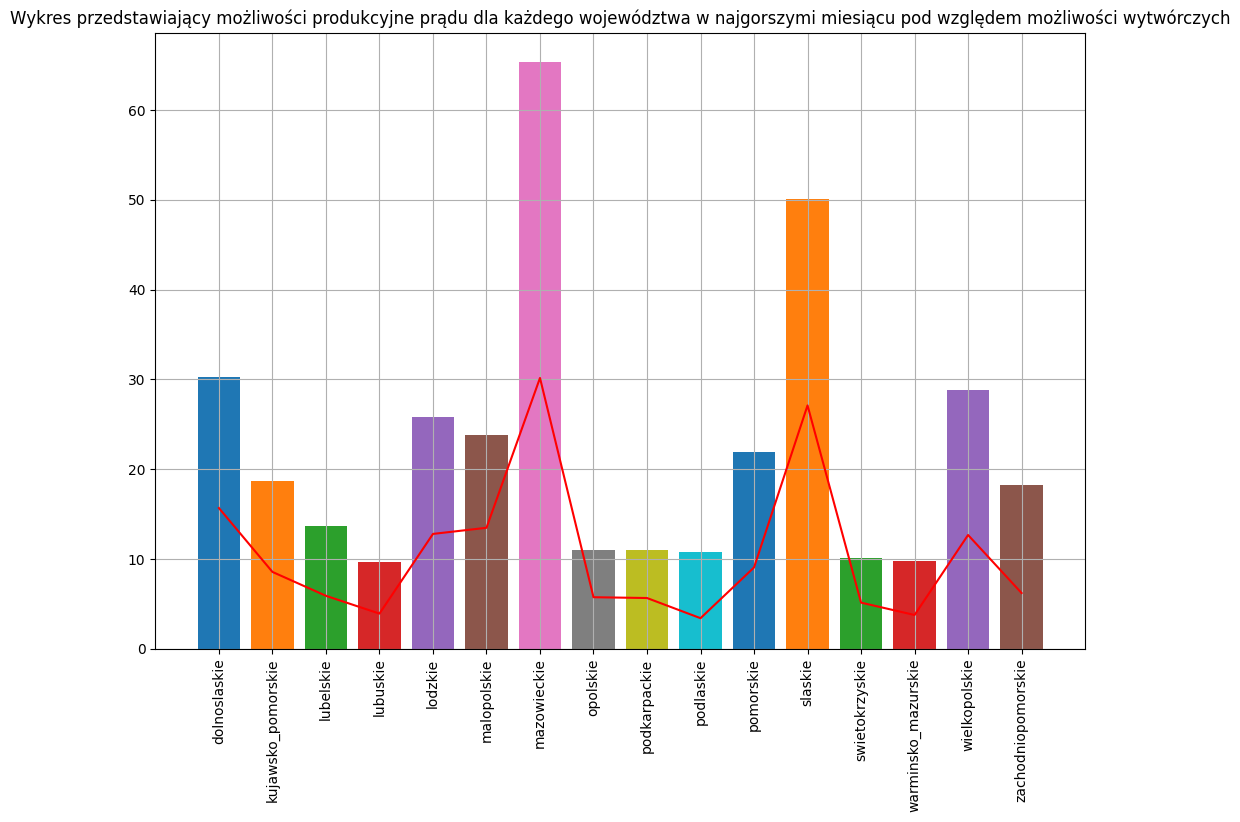

In [25]:
# Tworzenie wykresu
fig, ax1 = plt.subplots(figsize=(12, 8))

for province in provinces:
    
    ax1.bar(province, df_area_solar_wind[province]['energy_production_by_year_mwh'].sum() * 1e-6) #twh
    
plt.xticks(rotation=90)  # Ułatwia czytanie nazw miesięcy
plt.grid(True)
plt.plot(data_combined['Province'],data_combined['energy_consumption_2022'], color = 'red')

plt.title('Wykres przedstawiający możliwości produkcyjne prądu dla każdego województwa w najgorszymi miesiącu pod względem możliwości wytwórczych')
plt.show()    

In [26]:
df_area_solar_wind['podlaskie']

,id,province,type,area_km2,objective_value,building_cost_mln_zl,energy_production_by_year_mwh,january,february,march,april,may,june,july,august,september,october,november,december
0,1832.0,podlaskie,solar,0.03,0.30,10.28,7471.47,125.36,275.79,551.59,872.51,1118.21,1218.50,1153.31,937.69,631.82,345.99,155.45,85.24
1,1885.0,podlaskie,solar,0.06,0.30,20.98,15252.43,255.91,563.01,1126.02,1781.16,2282.75,2487.48,2354.40,1914.23,1289.80,706.32,317.33,174.02
2,1880.0,podlaskie,solar,0.06,0.30,21.77,15821.94,265.47,584.03,1168.06,1847.66,2367.98,2580.36,2442.31,1985.71,1337.96,732.69,329.18,180.52
3,1876.0,podlaskie,solar,0.07,0.30,24.78,18010.27,302.19,664.81,1329.62,2103.21,2695.50,2937.24,2780.11,2260.35,1523.02,834.03,374.71,205.49
4,1812.0,podlaskie,solar,0.09,0.30,30.29,22012.84,369.34,812.55,1625.11,2570.63,3294.54,3590.01,3397.96,2762.69,1861.49,1019.39,457.99,251.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,2886.0,podlaskie,wind,0.81,0.64,30620.86,5103.48,654.91,591.85,654.91,630.66,0.00,0.00,0.00,0.00,630.66,654.91,630.66,654.91
506,2904.0,podlaskie,wind,0.43,0.81,16285.18,2714.20,348.30,314.76,348.30,335.40,0.00,0.00,0.00,0.00,335.40,348.30,335.40,348.30
507,2909.0,podlaskie,wind,0.39,0.81,14826.76,2471.13,317.11,286.58,317.11,305.37,0.00,0.00,0.00,0.00,305.37,317.11,305.37,317.11
508,2911.0,podlaskie,wind,0.46,0.77,17436.89,2906.15,372.94,337.02,372.94,359.12,0.00,0.00,0.00,0.00,359.12,372.94,359.12,372.94


In [27]:
comb_all_area_solar_wind['december'].sum()*1e-6

8.249489125758252

In [28]:
for i in comb_all_area_solar_wind:
    print(i) 

id
province
type
area_km2
objective_value
building_cost_mln_zl
energy_production_by_year_mwh
january
february
march
april
may
june
july
august
september
october
november
december
all_solar_wind_cumsum_twh


In [29]:
df = comb_all_area_solar_wind

# # Grupa na podstawie 'id' i sprawdzenie, czy w 'province' lub 'type' są różne wartości
# df_grouped = df.groupby('id').filter(lambda x: x['province'].nunique() > 1 or x['type'].nunique() > 1)
# 
# # Teraz usuniemy duplikaty 'id', zachowując tylko pierwsze wystąpienie
# df_unique = df_grouped.drop_duplicates(subset=[['id','province','type']])

In [30]:
df_unique = df.drop_duplicates(subset=['id', 'province', 'type'],keep='first')

In [31]:
df_unique

,id,province,type,area_km2,objective_value,building_cost_mln_zl,energy_production_by_year_mwh,january,february,march,april,may,june,july,august,september,october,november,december,all_solar_wind_cumsum_twh
6050,167.0,lodzkie,wind,2.68,1.32,104887.05,17481.17,2720.37,1963.82,2173.07,2092.59,2173.07,0.0,0.0,0.0,2092.59,2173.07,2092.59,2173.07,0.02
6070,671.0,lodzkie,wind,0.82,1.32,32099.37,5349.90,832.53,601.00,665.04,640.41,665.04,0.0,0.0,0.0,640.41,665.04,640.41,665.04,0.02
6076,737.0,lodzkie,wind,0.51,1.32,19998.01,3333.00,518.67,374.43,414.32,398.98,414.32,0.0,0.0,0.0,398.98,414.32,398.98,414.32,0.03
6090,1213.0,lodzkie,wind,0.77,1.32,30121.86,5020.31,781.25,563.98,624.07,600.96,0.00,0.0,0.0,0.0,600.96,624.07,600.96,624.07,0.03
6069,646.0,lodzkie,wind,0.42,1.32,16548.00,2758.00,429.19,309.83,342.85,330.15,342.85,0.0,0.0,0.0,330.15,342.85,330.15,342.85,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,1661.0,malopolskie,wind,0.34,-0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,359.02
1706,2530.0,dolnoslaskie,wind,0.84,-0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,359.02
7512,1721.0,malopolskie,wind,1.12,-0.27,5461.61,910.27,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,910.27,359.02
7493,994.0,malopolskie,wind,0.94,-0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,359.02


In [32]:
duplicated_rows = comb_all_area_solar_wind.duplicated(subset=['id', 'province', 'type'])

# Wybranie tylko tych wierszy, które są duplikatami
df_duplicates = comb_all_area_solar_wind[duplicated_rows]
df_duplicates

,id,province,type,area_km2,objective_value,building_cost_mln_zl,energy_production_by_year_mwh,january,february,march,april,may,june,july,august,september,october,november,december,all_solar_wind_cumsum_twh


In [33]:
df_grouped = df.groupby('province')
df_grouped

In [34]:
df_area_solar_wind['pomorskie']

,id,province,type,area_km2,objective_value,building_cost_mln_zl,energy_production_by_year_mwh,january,february,march,april,may,june,july,august,september,october,november,december
0,2378.0,pomorskie,solar,0.02,0.30,6.73,4789.94,78.85,174.12,351.53,561.78,732.62,798.32,732.62,588.07,397.52,220.11,98.56,55.85
1,2991.0,pomorskie,solar,0.02,0.30,6.75,4800.74,79.02,174.51,352.32,563.05,734.27,800.12,734.27,589.39,398.41,220.61,98.78,55.98
2,2988.0,pomorskie,solar,0.02,0.30,6.76,4806.60,79.12,174.73,352.75,563.74,735.17,801.10,735.17,590.11,398.90,220.88,98.90,56.04
3,2640.0,pomorskie,solar,0.02,0.30,6.94,4936.09,81.25,179.43,362.25,578.92,754.97,822.68,754.97,606.01,409.65,226.83,101.57,57.55
4,1710.0,pomorskie,solar,0.02,0.30,7.36,5236.36,86.20,190.35,384.29,614.14,800.90,872.73,800.90,642.87,434.57,240.63,107.74,61.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,2378.0,pomorskie,wind,0.35,0.04,22324.71,3720.79,429.48,323.18,359.32,276.40,287.03,276.40,287.03,287.03,346.56,359.32,346.56,429.48
1312,2434.0,pomorskie,wind,0.59,0.15,22999.48,3833.25,596.52,430.62,476.51,458.86,0.00,0.00,0.00,0.00,458.86,476.51,458.86,476.51
1313,2435.0,pomorskie,wind,0.61,0.07,22999.11,3833.18,491.90,444.53,491.90,473.68,0.00,0.00,0.00,0.00,473.68,491.90,473.68,491.90
1314,2437.0,pomorskie,wind,0.56,-0.02,22065.03,3677.50,572.28,413.13,457.15,440.22,0.00,0.00,0.00,0.00,440.22,457.15,440.22,457.15


In [35]:
solar_radiation_photovoltaic_area_by_each_province['dolnoslaskie'][solar_radiation_photovoltaic_area_by_each_province['dolnoslaskie']['id']==4029]

,id,area_km2,line_distance_km,road_distance_km,solar_energy_production_mwh,january_solar_energy_production_mwh,february_solar_energy_production_mwh,march_solar_energy_production_mwh,april_solar_energy_production_mwh,may_solar_energy_production_mwh,...,solar_radiation_difference_kw,energy_production_by_year_mwh,road_distance_cost_parametr,line_distance_cost_parametr,solar_radiation_difference_parametr,solar_radiation_energy_parametr,type,province,objective_value,cumsum_tw
2954,4029.0,0.04,0.0,0.0,7.19,280.37,531.99,913.0,1322.77,1603.15,...,60,11768.38,0.0,0.0,0.42,0.99,solar,dolnoslaskie,0.24,1.32


In [36]:
a = 0
b = 0
for province in provinces:
    a +=solar_radiation_photovoltaic_area_by_each_province[province].shape[0]
    b += wind_energy_production_by_each_province[province].shape[0]
    
print(a)
print(b)

114189
2236
